In [1]:
# Standard Library Imports
import os
import tarfile
import json
import time

# Third-Party Library Imports
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar
import wandb
from PIL import ImageOps

# PyTorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# PyTorch-related Libraries
from torchvision.transforms import Resize, Pad
import torchvision.transforms.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torchvision.transforms import InterpolationMode

In [2]:
wandb.init(
    project="Deep-Learning-Exam",
    name="data_size_50",
    dir="./wandb_logs",
    config={
        "version": "v1.0.0",
        "learning_rate": 1e-4,
        "architecture": "UNet",
        "encoder": "resnet34",
        "dataset": "Kvasir-Instrument",
    },
    settings=wandb.Settings(init_timeout=900)
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: richardhansen (richardhansen-kristiania-university-college). Use `wandb login --relogin` to force relogin
wandb: WARNING Path ./wandb_logs\wandb\ wasn't writable, using system temp directory.


In [3]:
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

print(f"Using device: {device}")


PyTorch Version: 2.4.1+cu118
CUDA Available: True
CUDA Version: 11.8
GPU Name: NVIDIA GeForce RTX 4090
Using device: cuda


In [4]:
# Define dataset paths
dataset_dir = '../../data/kvasir-instrument'
images_tar = os.path.join(dataset_dir, 'images.tar.gz')
masks_tar = os.path.join(dataset_dir, 'masks.tar.gz')
train_txt = os.path.join(dataset_dir, 'train.txt')
test_txt = os.path.join(dataset_dir, 'test.txt')
images_dir = os.path.join(dataset_dir, 'images')
masks_dir = os.path.join(dataset_dir, 'masks')
bbox_json = os.path.join(dataset_dir, 'bboxes.json')

# Function to extract tar.gz files
def extract_tar(tar_path, extract_path):
    if not os.path.exists(extract_path):
        with tarfile.open(tar_path, "r:gz") as tar:
            tar.extractall(path=extract_path)
            print(f"Extracted {tar_path} to {extract_path}.")
    else:
        print(f"Directory {extract_path} already exists. Skipping extraction.")

# Function to load file splits
def load_split(file_path):
    return [line.strip() for line in open(file_path, 'r')] if os.path.exists(file_path) else []

# Verify files based on splits
def verify_files(filenames, directory, extensions=('.jpg', '.jpeg', '.png')):
    return [os.path.join(directory, f + ext) for f in filenames for ext in extensions if os.path.exists(os.path.join(directory, f + ext))]

# Extract dataset
extract_tar(images_tar, images_dir)
extract_tar(masks_tar, masks_dir)

# Load train and test splits
train_filenames = load_split(train_txt)
test_filenames = load_split(test_txt)

# Load bboxes.json
with open(bbox_json, 'r') as f:
    bboxes = json.load(f)



Directory ../../data/kvasir-instrument\images already exists. Skipping extraction.
Directory ../../data/kvasir-instrument\masks already exists. Skipping extraction.


In [5]:
class KvasirInstrumentDataset(Dataset):
    def __init__(self, images_dir, masks_dir, image_ids, target_size=(576, 576)):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_ids = image_ids
        self.target_size = target_size
        self.resize_to_target = Resize(self.target_size)

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.images_dir, f"{image_id}.jpg")
        mask_path = os.path.join(self.masks_dir, f"{image_id}.png")

        # Load and process the image
        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        # Pad to square to prevent stretching of the images.
        image, mask = self.pad_to_square(image, mask)
        
        # Initialize separate resize transforms for images and masks
        self.resize_to_target_image = Resize(self.target_size, interpolation=InterpolationMode.BILINEAR)
        self.resize_to_target_mask = Resize(self.target_size, interpolation=InterpolationMode.NEAREST)

        # Resize to target size
        image = self.resize_to_target_image(image)
        mask = self.resize_to_target_mask(mask)


        # Convert to tensors
        image = torch.tensor(np.array(image, dtype=np.float32) / 255.0).permute(2, 0, 1)  # [C, H, W]
        mask = torch.tensor(np.array(mask, dtype=np.float32) / 255.0).unsqueeze(0)  # [1, H, W]

        return image, mask

    def pad_to_square(self, image, mask):
        w, h = image.size
        max_side = max(w, h)
        left = (max_side - w) // 2
        top = (max_side - h) // 2
        right = max_side - w - left
        bottom = max_side - h - top
        padding = (left, top, right, bottom)

        image = ImageOps.expand(image, border=padding, fill=0)
        mask = ImageOps.expand(mask, border=padding, fill=0)

        return image, mask


In [6]:
torch.manual_seed(42)

# Initialize dataset and dataloader
train_size = int(0.9 * len(train_filenames))
val_size = int(len(train_filenames)) - train_size
train_ids, val_ids = random_split(train_filenames, [train_size, val_size])

# Create datasets
train_dataset = KvasirInstrumentDataset(images_dir, masks_dir, train_ids)
val_dataset = KvasirInstrumentDataset(images_dir, masks_dir, val_ids)
test_dataset = KvasirInstrumentDataset(images_dir, masks_dir, test_filenames)

# reduse the size of the train data set
# Reduce dataset to 75% of its original size
size_subset = int(len(train_dataset) * 0.5)
train_dataset, _ = random_split(train_dataset, [size_subset, len(train_dataset) - size_subset])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 212
Validation dataset size: 48
Test dataset size: 118


In [7]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        
        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024, dropout=0.1)
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512, dropout=0.2)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256, dropout=0.1)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        
        # Final Output
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def conv_block(self, in_channels, out_channels, dropout=None):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        ]
        if dropout is not None:
            layers.append(nn.Dropout2d(p=dropout))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))
        
        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        
        return self.final(dec1)

    def pool(self, x):
        return nn.MaxPool2d(kernel_size=2, stride=2)(x)


In [8]:
model = UNet(in_channels=3, out_channels=1).to(device)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # For binary segmentation tasks
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

c:\Projects\Deep-Learning\dpvenv\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [9]:
# Evaluation metrics
def iou_score(preds, masks):  # Intersection Over Union
    intersection = (preds * masks).sum((1, 2, 3))
    union = ((preds + masks) > 0).sum((1, 2, 3))
    return (intersection / union).mean().item()

def dice_coefficient(preds, masks):
    intersection = (preds * masks).sum((1, 2, 3))
    dice = (2 * intersection) / (preds.sum((1, 2, 3)) + masks.sum((1, 2, 3)))
    return dice.mean().item()

def precision(preds, masks):
    tp = (preds * masks).sum((1, 2, 3))  # True Positives
    fp = ((preds * (1 - masks))).sum((1, 2, 3))  # False Positives
    return (tp / (tp + fp + 1e-7)).mean().item()

def recall(preds, masks):
    tp = (preds * masks).sum((1, 2, 3))  # True Positives
    fn = ((1 - preds) * masks).sum((1, 2, 3))  # False Negatives
    return (tp / (tp + fn + 1e-7)).mean().item()

def f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall + 1e-7)

def pixel_accuracy(preds, masks):
    correct = (preds == masks).sum((1, 2, 3))
    total = torch.numel(preds[0])  # Total pixels per image
    return (correct / total).mean().item()


In [10]:
num_epochs = 25

# Define the training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, patience=3):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    model.to(device)

    total_training_start = time.time()

    train_losses = []
    val_losses = []
    train_ious = []
    val_ious = []
    train_dices = []
    val_dices = []

    for epoch in range(num_epochs):
        epoch_start = time.time()
        epoch_loss = 0
        epoch_iou = 0
        epoch_dice = 0
        epoch_precision = 0
        epoch_recall = 0
        epoch_pixel_acc = 0

        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        # Set model to training mode
        model.train()
        
        for images, masks in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True)
            
            # Forward pass
            outputs = model(images)
            preds = torch.sigmoid(outputs)
            loss = criterion(outputs, masks)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            # Threshold predictions at 0.5
            binary_preds = (preds > 0.5).float()

            # Calculate metrics
            epoch_iou += iou_score(binary_preds, masks)
            epoch_dice += dice_coefficient(binary_preds, masks)
            epoch_precision += precision(binary_preds, masks)
            epoch_recall += recall(binary_preds, masks)
            epoch_pixel_acc += pixel_accuracy(binary_preds, masks)
        
        # Average metrics over the epoch
        avg_loss = epoch_loss / len(train_loader)
        avg_iou = epoch_iou / len(train_loader)
        avg_dice = epoch_dice / len(train_loader)
        avg_precision = epoch_precision / len(train_loader)
        avg_recall = epoch_recall / len(train_loader)
        avg_pixel_acc = epoch_pixel_acc / len(train_loader)
        avg_f1 = f1_score(avg_precision, avg_recall)
        
        print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}, IoU: {avg_iou:.4f}, Dice: {avg_dice:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}, Pixel Acc: {avg_pixel_acc:.4f}")
        
        # Log to wandb
        wandb.log({
            "train_loss": avg_loss,
            "train_iou": avg_iou,
            "train_dice": avg_dice,
            "train_precision": avg_precision,
            "train_recall": avg_recall,
            "train_f1": avg_f1,
            "train_pixel_acc": avg_pixel_acc,
        })
        
        # Append **training metrics** to lists
        train_losses.append(avg_loss)
        train_ious.append(avg_iou)
        train_dices.append(avg_dice)
        
        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0
        val_iou = 0
        val_dice = 0

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True)
                outputs = model(images)
                preds = torch.sigmoid(outputs)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                
                # Threshold predictions
                binary_preds = (preds > 0.5).float()
                
                # Calculate metrics
                val_iou += iou_score(binary_preds, masks)
                val_dice += dice_coefficient(binary_preds, masks)
        
        # Average validation metrics
        avg_val_loss = val_loss / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        
        print(f"Validation Loss: {avg_val_loss:.4f}, IoU: {avg_val_iou:.4f}, Dice: {avg_val_dice:.4f}")
        
        # Append validation metrics to lists
        val_losses.append(avg_val_loss)
        val_ious.append(avg_val_iou)
        val_dices.append(avg_val_dice)

        # Scheduler step
        scheduler.step(avg_val_loss)

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print('Early stopping triggered')
                break
            
            
    total_training_time = time.time() - total_training_start
    
    print("Training complete")

    wandb.log({"total_training_time": total_training_time})

    # Plot Loss
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot IoU
    plt.figure(figsize=(10,5))
    plt.plot(train_ious, label='Training IoU')
    plt.plot(val_ious, label='Validation IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.title('Training and Validation IoU')
    plt.legend()
    plt.show()

    # Plot Dice Coefficient
    plt.figure(figsize=(10,5))
    plt.plot(train_dices, label='Training Dice')
    plt.plot(val_dices, label='Validation Dice')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.title('Training and Validation Dice Coefficient')
    plt.legend()
    plt.show()


Epoch 1/25


Training Epoch 1: 100%|██████████| 27/27 [00:13<00:00,  1.94it/s]


Epoch 1, Loss: 0.6043, IoU: 0.0000, Dice: 0.0000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, Pixel Acc: 0.9225
Validation Loss: 0.3724, IoU: 0.0000, Dice: 0.0000
Epoch 2/25


Training Epoch 2: 100%|██████████| 27/27 [00:13<00:00,  2.07it/s]


Epoch 2, Loss: 0.3049, IoU: 0.0000, Dice: 0.0000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, Pixel Acc: 0.9213
Validation Loss: 0.2388, IoU: 0.0000, Dice: 0.0000
Epoch 3/25


Training Epoch 3: 100%|██████████| 27/27 [00:12<00:00,  2.18it/s]


Epoch 3, Loss: 0.2506, IoU: 0.0000, Dice: 0.0000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, Pixel Acc: 0.9223
Validation Loss: 0.1925, IoU: 0.0000, Dice: 0.0000
Epoch 4/25


Training Epoch 4: 100%|██████████| 27/27 [00:12<00:00,  2.15it/s]


Epoch 4, Loss: 0.2081, IoU: 0.0000, Dice: 0.0000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, Pixel Acc: 0.9226
Validation Loss: 0.1524, IoU: 0.0000, Dice: 0.0000
Epoch 5/25


Training Epoch 5: 100%|██████████| 27/27 [00:12<00:00,  2.10it/s]


Epoch 5, Loss: 0.1608, IoU: 0.0000, Dice: 0.0000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, Pixel Acc: 0.9213
Validation Loss: 0.1357, IoU: 0.0000, Dice: 0.0000
Epoch 6/25


Training Epoch 6: 100%|██████████| 27/27 [00:12<00:00,  2.09it/s]


Epoch 6, Loss: 0.1454, IoU: 0.0139, Dice: 0.0190, Precision: 0.0938, Recall: 0.0143, F1: 0.0248, Pixel Acc: 0.9222
Validation Loss: 0.1212, IoU: 0.1663, Dice: 0.2099
Epoch 7/25


Training Epoch 7: 100%|██████████| 27/27 [00:12<00:00,  2.11it/s]


Epoch 7, Loss: 0.1399, IoU: 0.4077, Dice: 0.5178, Precision: 0.6970, Recall: 0.4950, F1: 0.5789, Pixel Acc: 0.9463
Validation Loss: 0.1254, IoU: 0.3979, Dice: 0.5152
Epoch 8/25


Training Epoch 8: 100%|██████████| 27/27 [00:12<00:00,  2.08it/s]


Epoch 8, Loss: 0.1317, IoU: 0.4430, Dice: 0.5563, Precision: 0.6876, Recall: 0.5608, F1: 0.6178, Pixel Acc: 0.9465
Validation Loss: 0.1211, IoU: 0.4036, Dice: 0.5225
Epoch 9/25


Training Epoch 9: 100%|██████████| 27/27 [00:13<00:00,  2.05it/s]


Epoch 9, Loss: 0.1234, IoU: 0.4916, Dice: 0.6073, Precision: 0.7235, Recall: 0.6036, F1: 0.6581, Pixel Acc: 0.9513
Validation Loss: 0.1137, IoU: 0.2521, Dice: 0.3362
Epoch 10/25


Training Epoch 10: 100%|██████████| 27/27 [00:13<00:00,  2.03it/s]


Epoch 10, Loss: 0.1308, IoU: 0.3997, Dice: 0.5068, Precision: 0.7316, Recall: 0.4733, F1: 0.5748, Pixel Acc: 0.9483
Validation Loss: 0.1237, IoU: 0.3940, Dice: 0.4948
Epoch 11/25


Training Epoch 11: 100%|██████████| 27/27 [00:13<00:00,  2.02it/s]


Epoch 11, Loss: 0.1239, IoU: 0.4859, Dice: 0.6001, Precision: 0.7388, Recall: 0.5971, F1: 0.6604, Pixel Acc: 0.9504
Validation Loss: 0.1353, IoU: 0.4703, Dice: 0.5911
Epoch 12/25


Training Epoch 12: 100%|██████████| 27/27 [00:12<00:00,  2.08it/s]


Epoch 12, Loss: 0.1249, IoU: 0.4744, Dice: 0.5852, Precision: 0.7992, Recall: 0.5504, F1: 0.6519, Pixel Acc: 0.9534
Validation Loss: 0.1119, IoU: 0.4531, Dice: 0.5770
Epoch 13/25


Training Epoch 13: 100%|██████████| 27/27 [00:13<00:00,  2.07it/s]


Epoch 13, Loss: 0.1133, IoU: 0.4712, Dice: 0.5853, Precision: 0.7818, Recall: 0.5585, F1: 0.6516, Pixel Acc: 0.9542
Validation Loss: 0.1042, IoU: 0.3852, Dice: 0.4979
Epoch 14/25


Training Epoch 14: 100%|██████████| 27/27 [00:12<00:00,  2.11it/s]


Epoch 14, Loss: 0.1124, IoU: 0.4829, Dice: 0.5947, Precision: 0.7872, Recall: 0.5658, F1: 0.6584, Pixel Acc: 0.9558
Validation Loss: 0.1068, IoU: 0.4341, Dice: 0.5532
Epoch 15/25


Training Epoch 15: 100%|██████████| 27/27 [00:12<00:00,  2.10it/s]


Epoch 15, Loss: 0.1109, IoU: 0.4948, Dice: 0.6078, Precision: 0.8113, Recall: 0.5741, F1: 0.6724, Pixel Acc: 0.9563
Validation Loss: 0.1019, IoU: 0.4655, Dice: 0.5887
Epoch 16/25


Training Epoch 16: 100%|██████████| 27/27 [00:13<00:00,  2.07it/s]


Epoch 16, Loss: 0.1050, IoU: 0.5215, Dice: 0.6347, Precision: 0.8107, Recall: 0.6028, F1: 0.6915, Pixel Acc: 0.9585
Validation Loss: 0.1090, IoU: 0.5010, Dice: 0.6223
Epoch 17/25


Training Epoch 17: 100%|██████████| 27/27 [00:12<00:00,  2.11it/s]


Epoch 17, Loss: 0.1093, IoU: 0.4793, Dice: 0.5891, Precision: 0.8034, Recall: 0.5513, F1: 0.6539, Pixel Acc: 0.9556
Validation Loss: 0.1002, IoU: 0.3968, Dice: 0.5104
Epoch 18/25


Training Epoch 18: 100%|██████████| 27/27 [00:12<00:00,  2.11it/s]


Epoch 18, Loss: 0.1152, IoU: 0.4808, Dice: 0.5930, Precision: 0.7929, Recall: 0.5810, F1: 0.6706, Pixel Acc: 0.9522
Validation Loss: 0.0979, IoU: 0.3799, Dice: 0.4909
Epoch 19/25


Training Epoch 19: 100%|██████████| 27/27 [00:12<00:00,  2.10it/s]


Epoch 19, Loss: 0.1054, IoU: 0.5109, Dice: 0.6288, Precision: 0.8171, Recall: 0.5956, F1: 0.6890, Pixel Acc: 0.9576
Validation Loss: 0.1263, IoU: 0.5218, Dice: 0.6448
Epoch 20/25


Training Epoch 20: 100%|██████████| 27/27 [00:13<00:00,  2.07it/s]


Epoch 20, Loss: 0.1056, IoU: 0.4912, Dice: 0.5973, Precision: 0.8106, Recall: 0.5665, F1: 0.6669, Pixel Acc: 0.9567
Validation Loss: 0.1047, IoU: 0.5502, Dice: 0.6617
Epoch 21/25


Training Epoch 21: 100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch 21, Loss: 0.1037, IoU: 0.5332, Dice: 0.6460, Precision: 0.8108, Recall: 0.6247, F1: 0.7057, Pixel Acc: 0.9582
Validation Loss: 0.0988, IoU: 0.5486, Dice: 0.6630
Early stopping triggered
Training complete


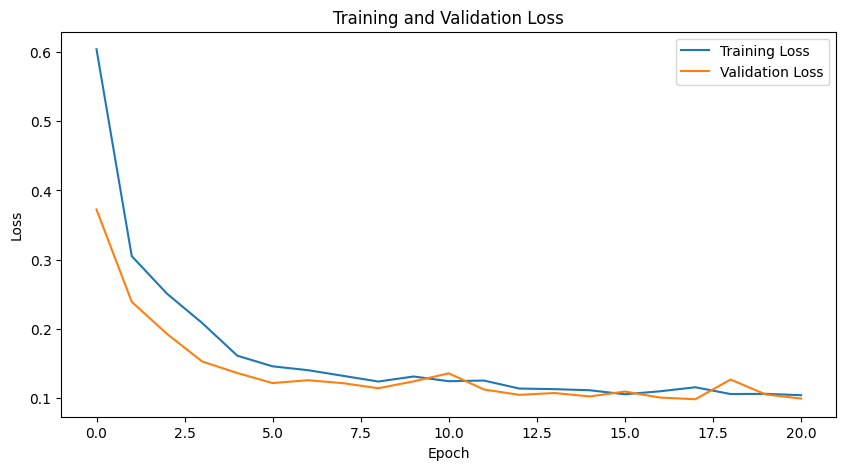

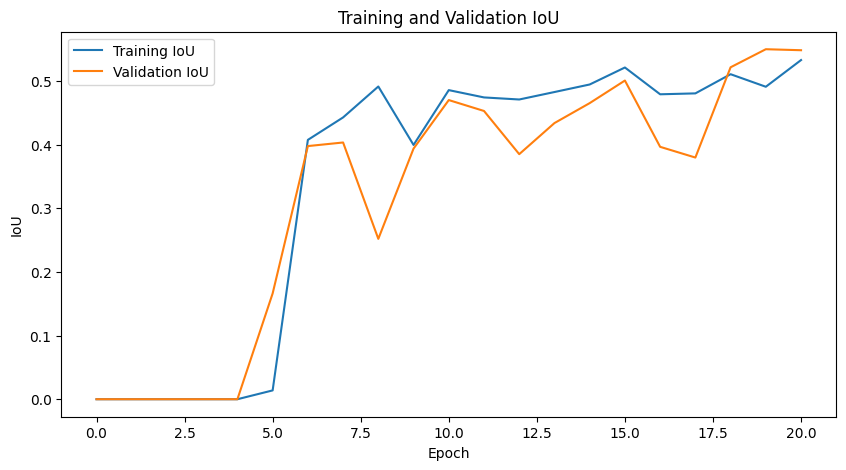

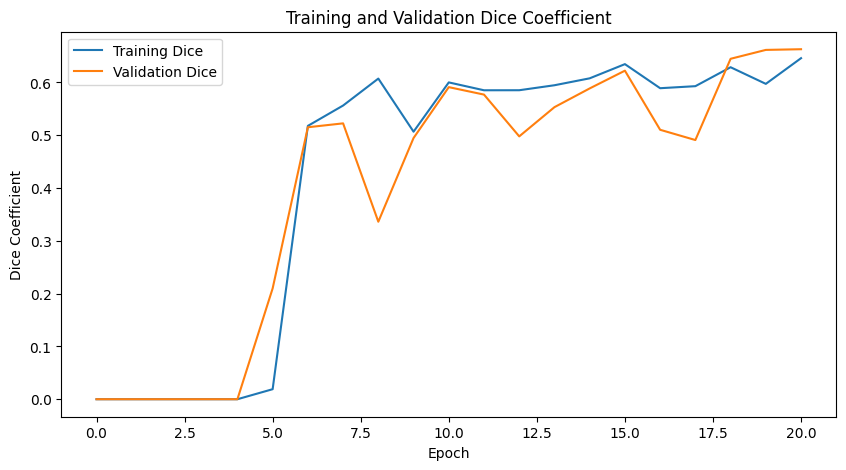

In [11]:
# Training
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, patience=3)

In [12]:
def eval_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    total_iou = 0
    total_dice = 0
    total_precision = 0
    total_recall = 0
    total_pixel_acc = 0
    results = []  # Store images, masks, and predictions for visualization

    with torch.no_grad():  # Disable gradient computation for evaluation
        for images, masks in tqdm(dataloader, desc="Evaluating"):
            images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True)
            outputs = model(images)
            preds = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities

            # Threshold predictions at 0.5
            binary_preds = (preds > 0.5).float()

            # Store the results for visualization
            results.append((images.cpu(), masks.cpu(), binary_preds.cpu()))

            # Calculate metrics
            total_iou += iou_score(binary_preds, masks)
            total_dice += dice_coefficient(binary_preds, masks)
            total_precision += precision(binary_preds, masks)
            total_recall += recall(binary_preds, masks)
            total_pixel_acc += pixel_accuracy(binary_preds, masks)

    # Average metrics
    avg_iou = total_iou / len(dataloader)
    avg_dice = total_dice / len(dataloader)
    avg_precision = total_precision / len(dataloader)
    avg_recall = total_recall / len(dataloader)
    avg_pixel_acc = total_pixel_acc / len(dataloader)
    avg_f1 = f1_score(avg_precision, avg_recall)

    print(f"Final Model Accuracy - IoU: {avg_iou:.4f}, Dice: {avg_dice:.4f}, "
          f"Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, "
          f"F1: {avg_f1:.4f}, Pixel Acc: {avg_pixel_acc:.4f}")

    # Log the evaluation metrics as scalars
    wandb.log({
        "eval_iou": avg_iou,
        "eval_dice": avg_dice,
        "eval_precision": avg_precision,
        "eval_recall": avg_recall,
        "eval_f1": avg_f1,
        "eval_pixel_acc": avg_pixel_acc,
    })

    return results  # Return the results for visualization


In [13]:
def visualize_results(results, num_samples=3):
    for i in range(num_samples):
        images, masks, preds = results[i]
        for j in range(images.shape[0]):  # Iterate over batch size
            plt.figure(figsize=(12, 4))
            
            # Calculate metrics
            iou = iou_score(preds[j].unsqueeze(0), masks[j].unsqueeze(0))
            dice = dice_coefficient(preds[j].unsqueeze(0), masks[j].unsqueeze(0))
            
            plt.subplot(1, 3, 1)
            plt.imshow(images[j].permute(1, 2, 0))  # Convert [C, H, W] to [H, W, C]
            plt.title("Original Image")
            plt.axis('off')
            
            plt.subplot(1, 3, 2)
            plt.imshow(masks[j][0], cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')
            
            plt.subplot(1, 3, 3)
            plt.imshow(preds[j][0], cmap='gray')
            plt.title(f"Predicted Mask\nIoU: {iou:.4f}, Dice: {dice:.4f}")
            plt.axis('off')
            
            plt.show()
            if i >= num_samples - 1:
                break


Evaluating: 100%|██████████| 30/30 [00:05<00:00,  5.04it/s]


Final Model Accuracy - IoU: 0.6355, Dice: 0.7482, Precision: 0.7683, Recall: 0.7939, F1: 0.7809, Pixel Acc: 0.9667


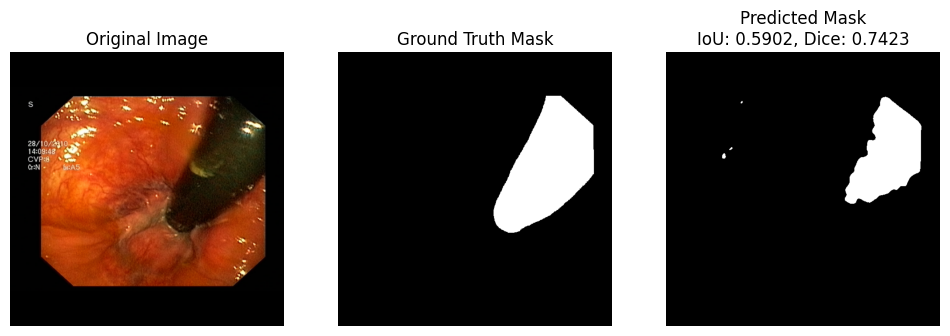

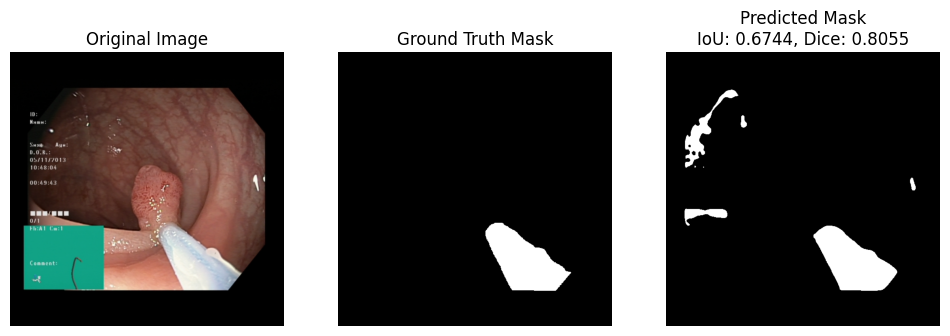

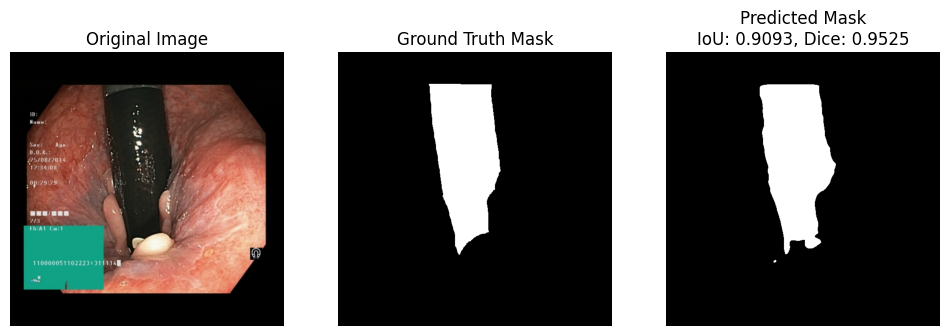

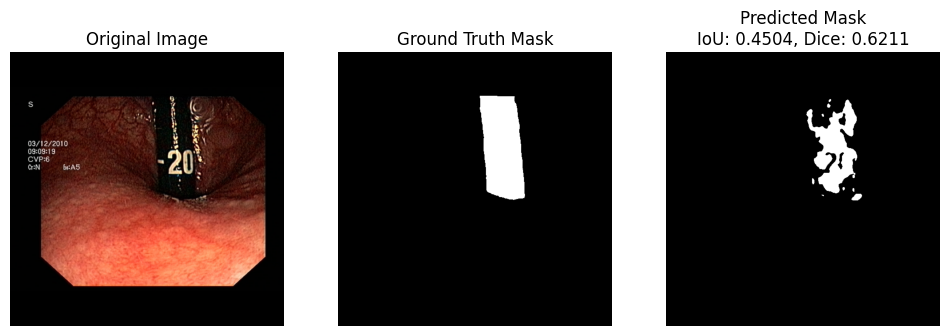

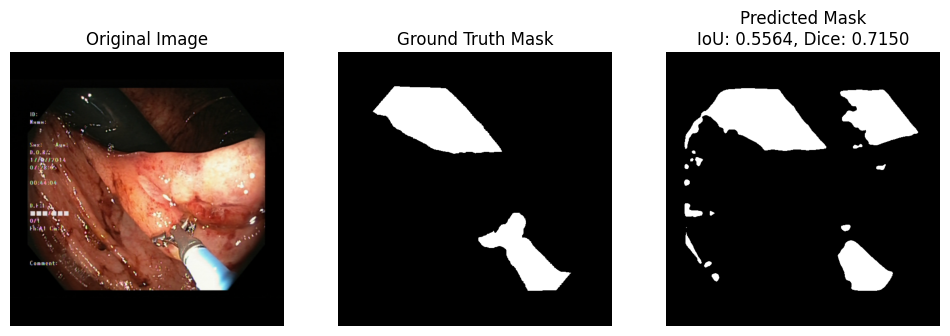

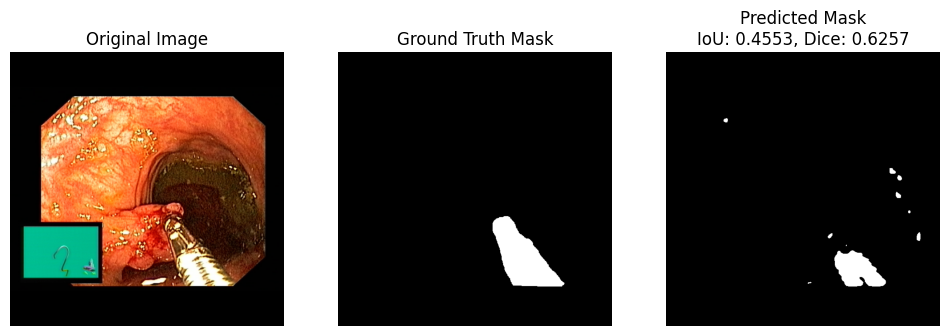

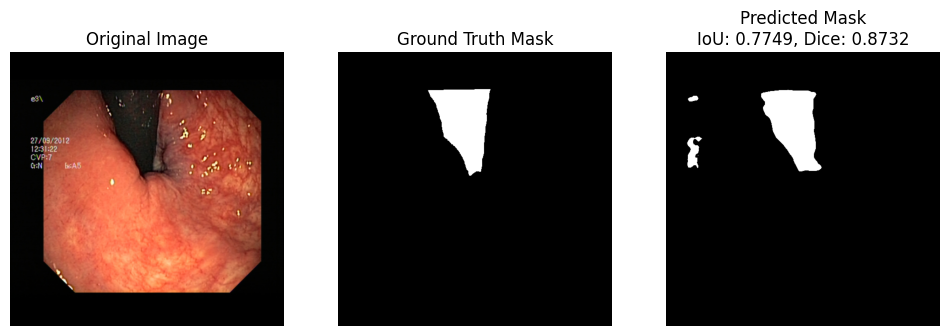

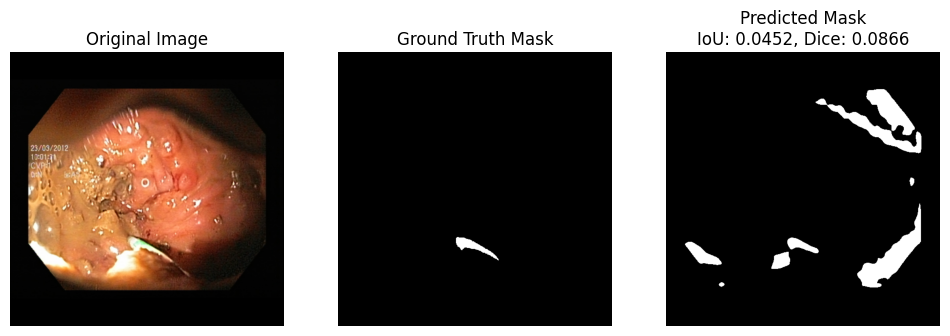

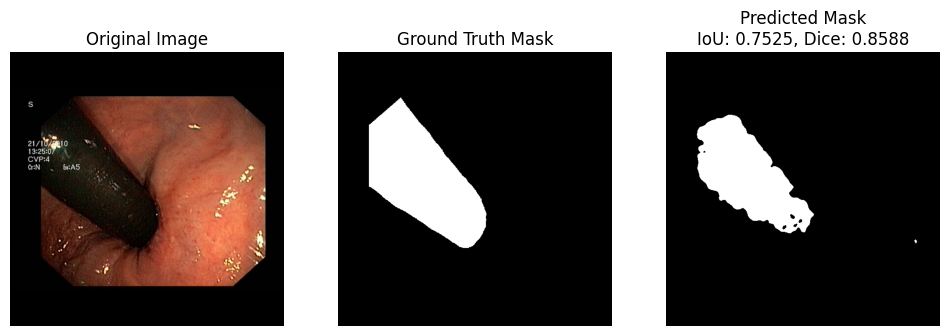

eval_dice,▁
eval_f1,▁
eval_iou,▁
eval_pixel_acc,▁
eval_precision,▁
eval_recall,▁
total_training_time,▁
train_dice,▁▁▁▁▁▁▇▇█▆█▇▇▇██▇▇█▇█
train_f1,▁▁▁▁▁▁▇▇█▇█▇▇███▇████
train_iou,▁▁▁▁▁▁▆▇▇▆▇▇▇▇▇█▇▇█▇█
train_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [14]:
# Load the best model
#model.load_state_dict(torch.load('best_model.pth'))

# Evaluate the model
results = eval_model(model, test_loader, device)

# Visualize results
visualize_results(results, num_samples=3)
wandb.finish()

In [15]:
# Cleanup Section to Clear Memory with Memory Tracking

import gc
import psutil

# Function to get current memory usage in GB
def get_memory_usage_gb():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 ** 3)  # Convert bytes to GB

# Memory usage before cleanup
memory_before = get_memory_usage_gb()

# List of variables to delete
vars_to_delete = [
    'model',
    'train_dataset',
    'val_dataset',
    'test_dataset',
    'train_loader',
    'val_loader',
    'test_loader',
    'optimizer',
    'scheduler',
    'criterion',
    'results',
    'preds',
    'binary_preds',
    'outputs',
    'images',
    'masks',
]

for var in vars_to_delete:
    if var in globals():
        del globals()[var]

# Clear CUDA cache if using GPU
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Collect garbage
gc.collect()

# Memory usage after cleanup
memory_after = get_memory_usage_gb()

# Display how much memory was cleared
memory_cleared = memory_before - memory_after
print(f"Memory before cleanup: {memory_before:.2f} GB")
print(f"Memory after cleanup: {memory_after:.2f} GB")
print(f"Memory cleared: {memory_cleared:.2f} GB")


Memory before cleanup: 1.93 GB
Memory after cleanup: 1.86 GB
Memory cleared: 0.07 GB
